In [1]:
import sys
sys.path.append("/home/shinzato/GitHub/power-law-research/power_law_research")

In [39]:
from datetime import datetime
import pytorch_lightning as pl
import torch

from models import LitVanillaVAE
from data_modules import FashionMNISTDataModule
from logzero import logger

tensorborad_dir = f"../log/exp01/{datetime.now().strftime('%Y-%m-%d_%H:%M:%S')}"
logger.info(f"Tensorboard directory: {tensorborad_dir}")
model = LitVanillaVAE(n_vis=784, n_hid=100, optimizer_name="sgd", normalize_loss=True)
data_module = FashionMNISTDataModule(batch_size=128)
trainer = pl.Trainer(
    max_epochs=1,
    devices=1,
    accelerator="gpu",
    auto_select_gpus=True,
    logger=pl.loggers.TensorBoardLogger(save_dir=f"{tensorborad_dir}/white"),
    enable_progress_bar=True,
)
trainer.fit(model, data_module)

[I 221125 12:28:54 398076747:10] Tensorboard directory: ../log/exp01/2022-11-25_12:28:54
Auto select gpus: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ../log/exp01/2022-11-25_12:28:54/white/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name         | Type       | Params
--------------------------------------------
0 | encoder_mean | Sequential | 78.5 K
1 | encoder_var  | Sequential | 78.5 K
2 | decoder      | Sequential | 79.2 K
--------------------------------------------
236 K     Trainable params
0         Non-trainable params
236 K     Total params
0.945     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


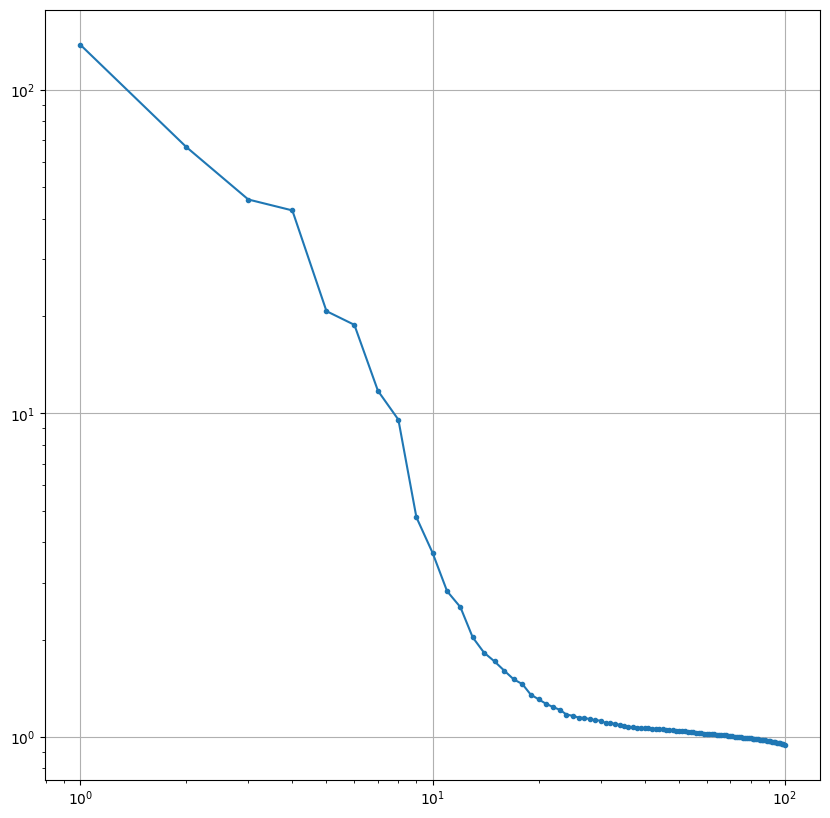

In [42]:
import numpy as np
import matplotlib.pyplot as plt

from utils import pca_variance


firings = model.sample_neuron_firings(dataloader=data_module.train_dataloader())
pc_dim, pc_var = pca_variance(firings)
log_pc_dim, log_var = np.log(pc_dim), np.log(pc_var)


fig, ax = plt.subplots(figsize=(10, 10))
ax.grid()
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(pc_dim, pc_var, ".-")

In [41]:
dataloader=data_module.train_dataloader()
hidden_means = []
hidden_vars = []
for idx, d in enumerate(dataloader):
    data, target = d
    x = data.view(data.size(0), -1)
    h_mean = model.encoder_mean(x).detach()
    h_var = model.encoder_var(x).detach()
    hidden_means.append(h_mean)
    hidden_vars.append(h_var)
    
hidden_mean = torch.cat(hidden_means).numpy()
hidden_var = torch.cat(hidden_vars).numpy()

  0%|          | 0/4 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

 25%|██▌       | 1/4 [00:47<02:21, 47.18s/it]

Training: 0it [00:00, ?it/s]

 50%|█████     | 2/4 [01:32<01:32, 46.12s/it]

Training: 0it [00:00, ?it/s]

 75%|███████▌  | 3/4 [02:19<00:46, 46.36s/it]

Training: 0it [00:00, ?it/s]

100%|██████████| 4/4 [03:05<00:00, 46.39s/it]


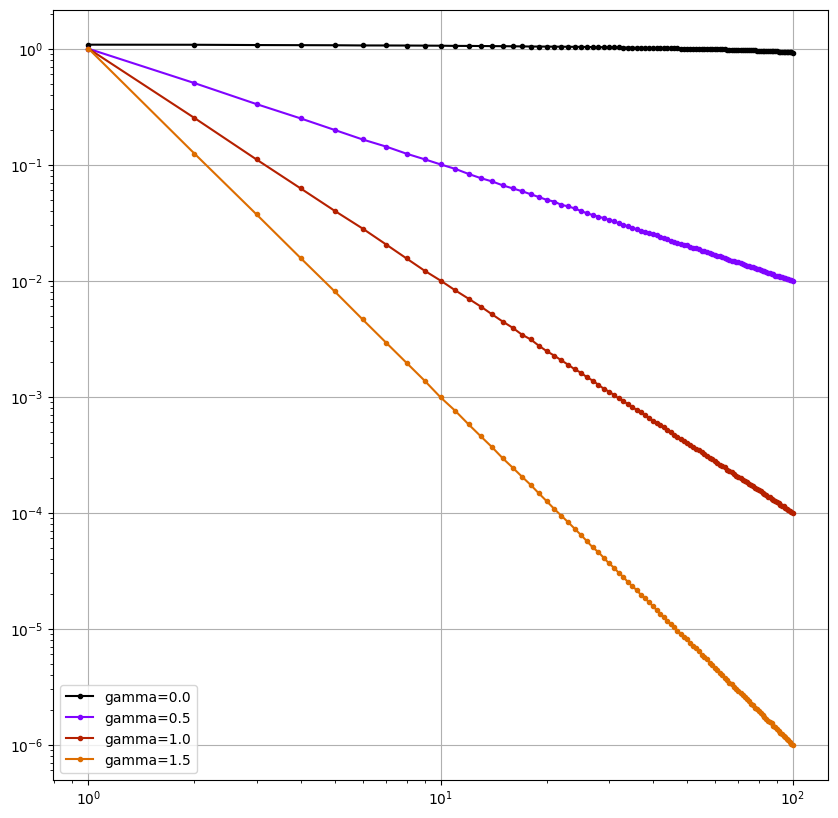

In [3]:
from datetime import datetime
import pytorch_lightning as pl

from models import LitVanillaVAE
from data_modules import FashionMNISTDataModule
from logzero import logger
import numpy as np
from utils import sample_neuron_firings, pca_variance
from models import LitScaleFreeVAE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import logging

from tqdm import tqdm

fig, ax = plt.subplots(figsize=(10, 10))

ax.grid()
ax.set_xscale("log")
ax.set_yscale("log")
epoch_loss_dicts = {}

tensorborad_dir = f"../log/exp03"
n_sample = 4
for i, gamma in enumerate(tqdm([0.5 * i for i in range(n_sample)])):
    model = LitScaleFreeVAE(n_vis=784, power_law_gamma=gamma)
    logger = pl.loggers.TensorBoardLogger(
        save_dir=f"{tensorborad_dir}/vary_gamma/{str(datetime.now())}_scalefree_gamma_{gamma:.2}"
    )
    logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
    data_module = FashionMNISTDataModule(batch_size=128)
    trainer = pl.Trainer(
        max_epochs=10, devices=1, accelerator="gpu", logger=logger
    )
    trainer.fit(model, data_module)

    epoch_loss_dicts[f"{gamma:.2}"] = model.epoch_loss_dict

    firings = sample_neuron_firings(model, data_module.train_dataloader())
    pc_dim, pc_var = pca_variance(firings)
    ax.plot(pc_dim, pc_var, ".-", label=f"gamma={gamma:.2}", color=cm.gnuplot(i / n_sample))
    ax.legend()

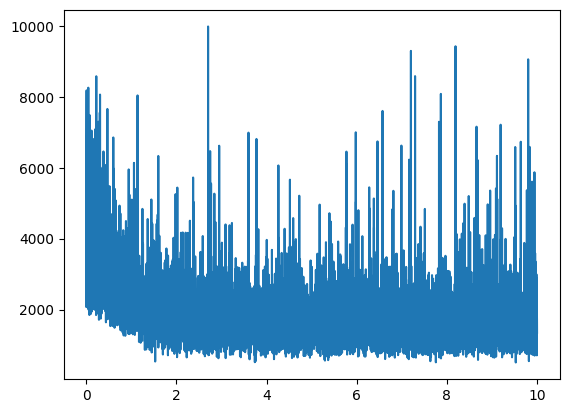

In [1]:
gammas = []
ave_losss = []
upper_th = 1e4
batch_size = 512

with open("gamma_loss_ave_0.001.csv") as fp:
    for line in fp:
        row = line.split(",")
        gamma = float(row[0])
        ave_loss = float(row[1]) / batch_size
        if ave_loss > upper_th:
            continue
        gammas.append(gamma)
        ave_losss.append(ave_loss)
        
import matplotlib.pyplot as plt

plt.plot(gammas, ave_losss)

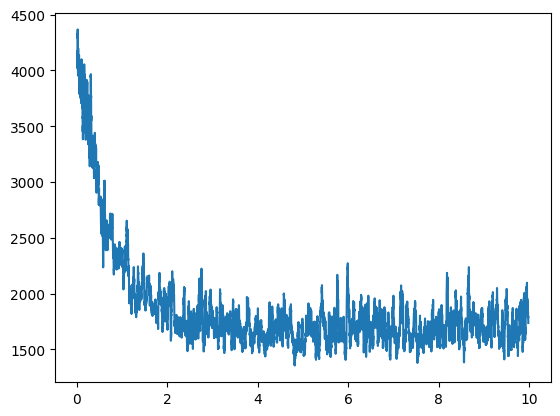

In [2]:
import numpy as np

ofset = 30
gamma_smooth = gammas[(ofset//2-1):-ofset//2]
smooth = np.convolve(ave_losss, np.ones(ofset)/ofset, mode="valid")
plt.plot(gamma_smooth, smooth)
